Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io

ampis_root = str(Path('..','..'))
import sys
if ampis_root not in sys.path:
    sys.path.append(ampis_root)

from ampis import analyze, data_utils
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset

%matplotlib inline

# Loading Data
For evaluating the segmentation performance, we need to load back the original ground truth labels.

In [5]:
## load ground truth labels

via_path = Path('data','via_2.0.8')

particles_gt_path_train = via_path / 'via_powder_particle_training_W2.json'
particles_gt_path_valid = via_path / 'via_powder_particle_validation_W2.json'

satellites_gt_path_train = via_path / 'via_powder_satellite_training_W2.json'
satellites_gt_path_valid = via_path / 'via_powder_satellite_validation_W2.json'

for path in [particles_gt_path_train, particles_gt_path_valid, satellites_gt_path_train, satellites_gt_path_valid]:
    assert path.is_file(), f'File not found : {path}'

particles_gt_dd_train = data_utils.get_ddicts('via2', particles_gt_path_train, dataset_class='train')
particles_gt_dd_valid = data_utils.get_ddicts('via2', particles_gt_path_valid, dataset_class='validation')

satellites_gt_dd_train = data_utils.get_ddicts('via2', satellites_gt_path_train, dataset_class='train')
satellites_gt_dd_valid = data_utils.get_ddicts('via2', satellites_gt_path_valid, dataset_class='validation')

You can use your own predictions generated from before by replacing the paths, but as an example I am including mine from the fully trained model.

In [6]:
## load predicted labels

particles_path = Path('data','particle-results_W2.pickle')
assert particles_path.is_file()

satellites_path = Path('data','satellite-results_W2.pickle')
assert satellites_path.is_file()

with open(particles_path, 'rb') as f:
    particle_pred = pickle.load(f)

with open(satellites_path, 'rb') as f:
    satellites_pred = pickle.load(f)

## Load data to InstanceSet objects
To standardize the format of the ground truth and predicted instances, and for convenient analysis, everything is loaded into an InstanceSet class object.

In [7]:
# Ground truth instance sets

iset_particles_gt = [InstanceSet().read_from_ddict(x,   # data 
                                                   inplace=False  # returns the set so it can be added to the list
                                                  ) for x in particles_gt_dd_train]

# instead of creating a separate list, we add the validation results to the training ones to make it easier later
iset_particles_gt.extend([InstanceSet().read_from_ddict(x, inplace=False) for x in particles_gt_dd_valid])

iset_satellites_gt = [InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd_train]
iset_satellites_gt.extend([InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd_valid])

# Predicted instance sets
iset_particles_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in particle_pred]
iset_satellites_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in satellites_pred]

iset_particles_gt

## Match order of ground truth and predicted data
We want to rearrange the order of the instance sets in the ground truth and predicted lists so that the files are in the same order. This will make it easier later.

In [8]:
iset_particles_gt, iset_particles_pred = analyze.align_instance_sets(iset_particles_gt, iset_particles_pred)
iset_satellites_gt, iset_satellites_pred = analyze.align_instance_sets(iset_satellites_gt, iset_satellites_pred)

for gt, pred in zip(iset_particles_gt, iset_particles_pred):
    pred.HFW = gt.HFW
    pred.HFW_units = gt.HFW_units
    print(f'gt filename: {Path(gt.filepath).name}\t pred filename: {Path(pred.filepath).name}')

gt filename: S02_02_SE1_1000X20.png	 pred filename: S02_02_SE1_1000X20.png
gt filename: S03_01_SE1_1250X28.png	 pred filename: S03_01_SE1_1250X28.png
gt filename: S05_01_SE1_300X56.png	 pred filename: S05_01_SE1_300X56.png
gt filename: S05_03_SE1_300X63.png	 pred filename: S05_03_SE1_300X63.png
gt filename: S07_03_SE1_1000X91.png	 pred filename: S07_03_SE1_1000X91.png
gt filename: S01_03_SE1_300X10.png	 pred filename: S01_03_SE1_300X10.png


# Compute detection and segmentation scores (precesion and recall)

In [9]:
dss_particles = [analyze.det_seg_scores(gt, pred, size=gt.instances.image_size) 
                 for gt, pred in zip(iset_particles_gt, iset_particles_pred)]
dss_satellites = [analyze.det_seg_scores(gt, pred, size=gt.instances.image_size)
                 for gt, pred in zip(iset_satellites_gt, iset_satellites_pred)]

##  Plot detection results for particles

In [10]:
labels = []
counts = {'train': 0, 'validation': 0}

# the filenames are not helpful, so we will map them to labels ie ('Train 1', 'Train 2', 'Validation 1', etc)
for iset in iset_particles_gt:
    counts[iset.dataset_class] += 1
    labels.append('{} {}'.format(iset.dataset_class, counts[iset.dataset_class]))

# x values are arbitrary, we just want 2 values, 1 for precision, 2 for recall
x=[*([1] * len(labels)), *([2] * len(labels))]
# y values are the bar heights
scores = [*[x['det_precision'] for x in dss_particles],
     *[x['det_recall'] for x in dss_particles]]

# since we are plotting precision and recall on the same plot we need 2 sets of labels
labels = labels * 2
print('x: ', x)
print('y: ', [np.round(x, decimals=2) for x in scores])
print('labels: ', labels)

x:  [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
y:  [0.61, 1.0, 1.0, 1.0, 0.2, 0.68, 1.0, 0.93, 1.0, 1.0, 0.62, 0.95]
labels:  ['train 1', 'train 2', 'train 3', 'train 4', 'train 5', 'validation 1', 'train 1', 'train 2', 'train 3', 'train 4', 'train 5', 'validation 1']


[Text(0, 0, 'precision'), Text(0, 0, 'recall')]

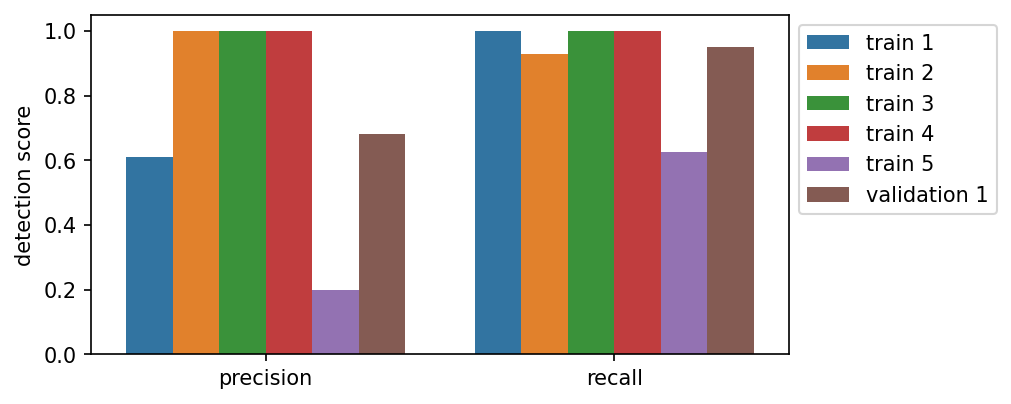

In [11]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
sns.barplot(x=x, y=scores, hue=labels, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('detection score')
ax.set_xticklabels(['precision','recall'])

## Visualize detection results for powder
Detection results indicate which predicted instances matched with a corresponding ground truth instance with IOU score of at least 0.5.
True positives (matches) are shown in purple. False positives (unmatched predicted instances) are shown in blue. False negatives (unmatched gt instances) are shown in red.

[<ampis.structures.InstanceSet object at 0x154dadb21100>, <ampis.structures.InstanceSet object at 0x154dadb21250>, <ampis.structures.InstanceSet object at 0x154dadd80eb0>, <ampis.structures.InstanceSet object at 0x154dadb213a0>, <ampis.structures.InstanceSet object at 0x154dadb21490>, <ampis.structures.InstanceSet object at 0x154dadb21160>]
[<ampis.structures.InstanceSet object at 0x154dad9d6580>, <ampis.structures.InstanceSet object at 0x154dad9d6790>, <ampis.structures.InstanceSet object at 0x154dad9d68e0>, <ampis.structures.InstanceSet object at 0x154dad9d6940>, <ampis.structures.InstanceSet object at 0x154dad9d6a30>, <ampis.structures.InstanceSet object at 0x154dad9d6b20>]


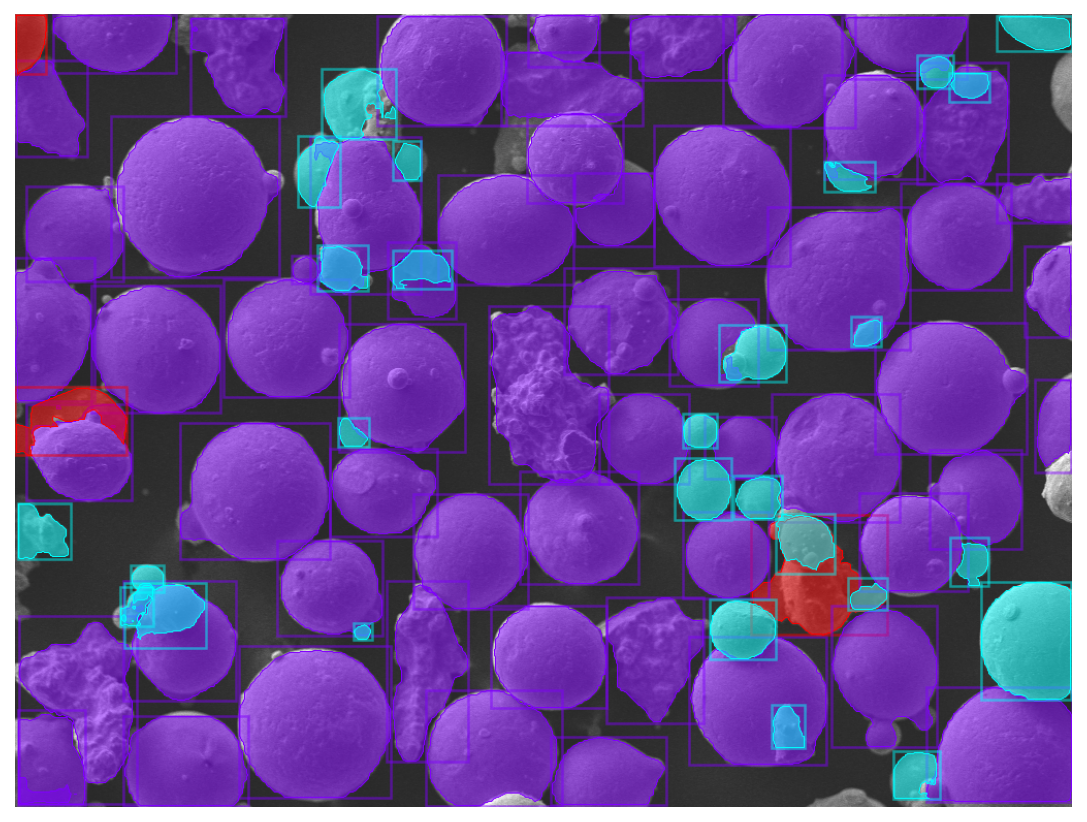

In [27]:
'''for i in range(len(iset_particles_gt)):
    gt = iset_particles_gt[i]
    pred = iset_particles_pred[i]
    iset_det, colormap = analyze.det_perf_iset(gt, pred)
    img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))
    display_iset(img, iset=iset_det)'''
print(iset_particles_gt)
print(iset_particles_pred)
gt = iset_particles_gt[-1]
pred = iset_particles_pred[-1]
iset_det, colormap = analyze.det_perf_iset(gt, pred)
img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))
display_iset(img, iset=iset_det)

## Visualize segmentation results for powder

Segmentation results indicate how well each matched pair of masks agrees. True positives (included in both gt and pred masks) are shown in purple, false positive pixels (included in pred but not gt) are shown in blue, and false negative pixels (included in gt but not pred) are shown in red.

Detectron2 appears to smooth out masks, which can affect the display of discontinuous masks here. This can affect the display of the mask visualization, so we pass apply_correction=True to prevent this.

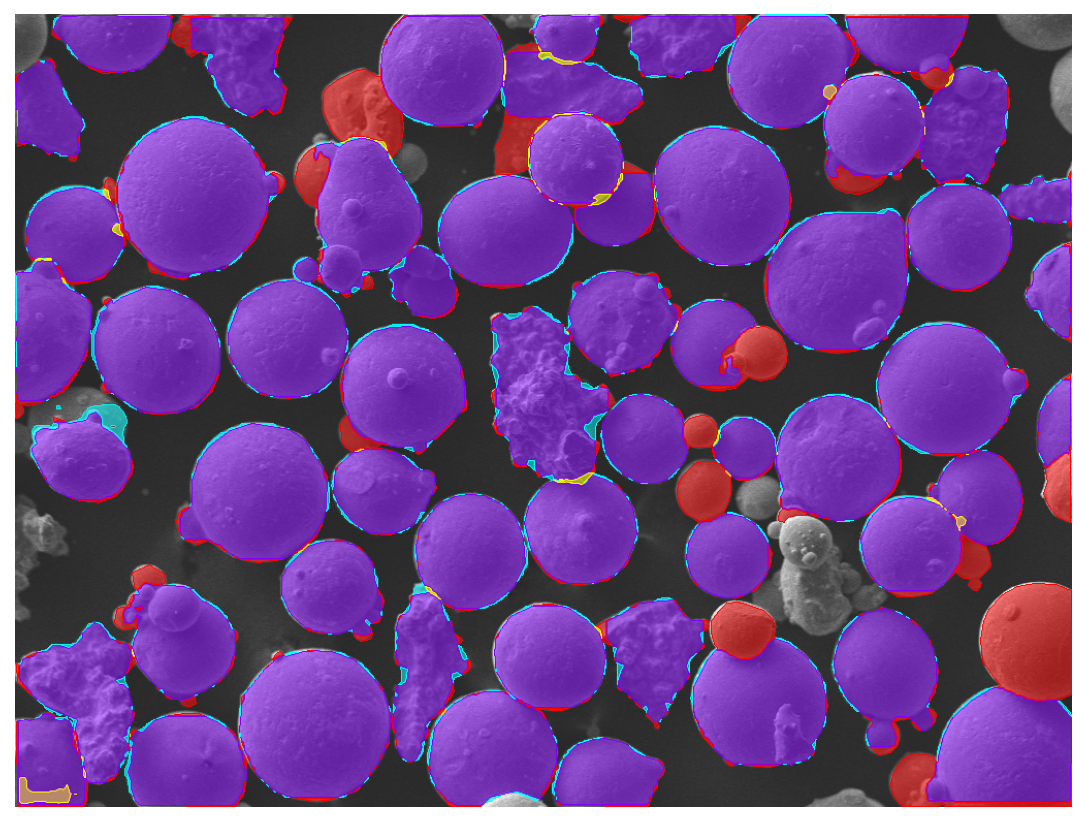

[<ampis.structures.InstanceSet object at 0x154dadb21760>, <ampis.structures.InstanceSet object at 0x154dadb21730>, <ampis.structures.InstanceSet object at 0x154dadb217f0>, <ampis.structures.InstanceSet object at 0x154dadb21910>, <ampis.structures.InstanceSet object at 0x154dadb21af0>, <ampis.structures.InstanceSet object at 0x154dadb21be0>, <ampis.structures.InstanceSet object at 0x154dadb21cd0>, <ampis.structures.InstanceSet object at 0x154dadb21fa0>, <ampis.structures.InstanceSet object at 0x154dad9d60d0>, <ampis.structures.InstanceSet object at 0x154dad9d61c0>, <ampis.structures.InstanceSet object at 0x154dad9d62b0>, <ampis.structures.InstanceSet object at 0x154dadb21820>, <ampis.structures.InstanceSet object at 0x154dad9d64c0>, <ampis.structures.InstanceSet object at 0x154dad9d6550>]

[<ampis.structures.InstanceSet object at 0x154dad9d6850>, <ampis.structures.InstanceSet object at 0x154dad9f1970>, <ampis.structures.InstanceSet object at 0x154dad9f1790>, <ampis.structures.InstanceSe

In [21]:
iset_seg, (colors, color_labels) = analyze.seg_perf_iset(gt, pred,)
display_iset(img, iset=iset_seg, apply_correction=True)
print(iset_satellites_gt)
print('')
print(iset_satellites_pred)

## Visualize match results for satellites
The process above can be repeated exactl to analyze the satellite results.

In [23]:
# select instances for the same image
gt_s, pred_s = [(x, y) for x, y in zip(iset_satellites_gt, iset_satellites_pred) if str(x.filepath) == pred.filepath][0]

iset_det_s, colormap_s = analyze.det_perf_iset(gt_s, pred_s)


#display_iset(img, iset=iset_det_s)

IndexError: list index out of range

# Powder Characterization- Size Distribution

Once we have the masks it is pretty trivial to compute various properties. With binary masks we can use [skimage regionprops] (https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops), which provides many convenient measurements out of the box. If there are any additional measurements you need, you can also access the masks directly and define your own methods. 

In [18]:
for iset in [*iset_particles_gt, *iset_particles_pred]:
    if iset.rprops is None:  # avoid re-computing regionprops if cell has already been run
        iset.compute_rprops()  # since rprops requires the masks to be uncompressed, this takes a bit longer to run
iset_particles_pred[-1].rprops.head()

,area,equivalent_diameter,major_axis_length,perimeter,solidity,orientation,class_idx
0,[11079],[118.7696127640436],[124.0401600922905],[399.2203461105328],[0.9788831949107616],[1.5420427080881742],0
1,[2779],[59.48388600973391],[86.87082595886525],[234.71067811865476],[0.9635922330097088],[0.003907109850091101],0
2,[1480],[43.40961329254202],[44.70723184047296],[144.22539674441617],[0.9730440499671269],[-0.5646683223400973],0
3,[6371],[90.06558243584351],[99.59067888335795],[306.492424049175],[0.974307998164857],[1.3648380763757657],0
4,[13635],[131.7597100500147],[135.86511558188366],[451.34523779156063],[0.9717767799871713],[-1.514172518383264],0


Note that the measurements are in terms of pixels. If the conversion for pixels to microns is known, then we can generate equivalent measurements.

In [19]:
print('ground truth PSD')
areas_gt = powder.psd(iset_particles_gt)
print('predicted PSD')
areas_pred = powder.psd(iset_particles_pred)



ground truth PSD


ValueError: Cannot infer c because HFW is not defined

# Satellite content measurements
The process here is fairly straightforward. We have masks for powder particles and masks for satellites. To match the satellites to their corresponding particles, we simply overlay the masks and look for intersections. Then, it is trivial to count the number of particles containing satellites. 



We have more labeled satellite images than particle images. We only want to keep images that have labels for both particles and satellites.
To help with the implementation, we can combine the masks for particles and satellites in the PowderSatelliteImage class

In [20]:
iset_particles_gt_ss, iset_satellites_gt_ss = analyze.align_instance_sets(iset_particles_gt, iset_satellites_gt)
iset_particles_pred_ss, iset_satellites_pred_ss = analyze.align_instance_sets(iset_particles_pred, iset_satellites_pred)
psi_gt = []
psi_pred = []
for pg, pp, sg, sp in zip(iset_particles_gt_ss, iset_particles_pred_ss, iset_satellites_gt_ss, iset_satellites_pred_ss):
    files = [Path(x).name for x in [pg.filepath, pp.filepath, sg.filepath, sp.filepath]]
    assert all([x == files[0] for x in files])  # the files are in the same order and there are no excess files
    psi_gt.append(powder.PowderSatelliteImage(particles=pg, satellites=sg))
    psi_pred.append(powder.PowderSatelliteImage(particles=pp, satellites=sp))


In [21]:
for gt, pred in zip(psi_gt, psi_pred):
    for psi in [gt, pred]:
        psi.compute_matches()

The matches for psi are stored in psi.matches as a dictionary. The key 'match_pairs' returns a dictionary whose keys are indices of particle masks that contain satellites. The value corresponding to each key is a list of indices of satellite masks that matched (note that multiple satellites can match with a single particle.)

Text(0.5, 1.0, 'predicted')

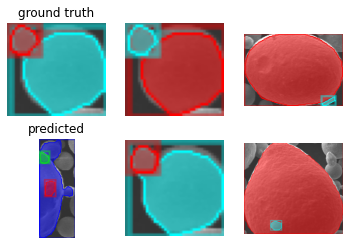

In [22]:
gt = psi_gt[0]
pred = psi_pred[0]

gt_idx = np.random.choice(list(gt.matches['match_pairs'].keys()), 3)
pred_idx = np.random.choice(list(pred.matches['match_pairs'].keys()), 3)

fig, ax = plt.subplots(2,3)


for i, (g, p) in enumerate(zip(gt_idx, pred_idx)):
    gt.visualize_particle_with_satellites(g, ax[0, i])
    pred.visualize_particle_with_satellites(p, ax[1, i])
ax[0,0].set_title('ground truth')
ax[1,0].set_title('predicted')

To compute the ratio of satellited particles, we can get the total number of 

## Final satellite measurements

The number of satellites in each set, fraction of satellited particles, and some other information can be displayed with one command.
The results can be printed directly, and are also returned

In [23]:
print('ground truth results')
results_gt = powder.satellite_measurements(psi_gt, print_summary=True, output_dict=True)
print('predicted results')
results_pred = powder.satellite_measurements(psi_pred, True, True)


ground truth results
number of images                   	3
number of particles                	390
number of matched satellites       	172
number of unmatched satellites     	3
number of satellited particles     	108
fraction of satellited particles   	0.27692307692307694
median number of satellites per
satellited particle             	1.0
predicted results
number of images                   	3
number of particles                	369
number of matched satellites       	162
number of unmatched satellites     	6
number of satellited particles     	107
fraction of satellited particles   	0.2899728997289973
median number of satellites per
satellited particle             	1.0


The results are (optionally) returned as a dictionary in case you need to store them for further analysis or post processing.

In [24]:
results_gt

{'n_images': 3,
 'n_particles': 390,
 'n_satellites': 172,
 'n_satellites_unmatched': 3,
 'n_satellited_particels': 108,
 'sat_frac': 0.27692307692307694,
 'mspp': 1.0,
 'unique_satellites_per_particle': array([1, 2, 3, 4, 5, 8]),
 'counts_satellites_per_particle': array([0.64814815, 0.90740741, 0.92592593, 0.9537037 , 0.99074074,
        1.        ])}